# **Modelo de clasificación para caracteres japoneses**

# **Entendimiento del caso**
---

## **1. Contexto**
---
En este proyecto se usará un conjunto de datos con muestras de diez **`caracteres`** del alfabeto japonés en formato de imágenes de $28 \times 28$ pixeles. Se buscará clasificar dichas imágenes según su símbolo correcto.

## **2. Categorías**
---
Cabe anotar que el autor de este conjunto de datos etiquetó los símbolos como:

<img src = "https://drive.google.com/uc?id=1C65CCMBdkC2t6GLLSuxd-LEm7E521muw" alt = "kana1">  </img>

Pero algunas de las imágenes están nombradas incorrectamente, pues los símbolos a los que realmente corresponden son:

<img src = "https://drive.google.com/uc?id=1tnaEahgokstS3Xx1PRXMQkUPWTEKc56d" alt = "kana2">  </img>

Lo anterior no afectará al presente estudio, porque la variable objetivo estará representada como un número entre $0$ y $9$. Entonces es indiferente a qué caracteres corresponden los dígitos.

# **Entendimiento de los datos**
---

## **1. Adquisición de datos**
---

In [ ]:
!pip install -U scikit-learn

import sklearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 75.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
# Módulos estándar
from random import seed, randint
seed(30)

import numpy as np
import pandas as pd

from sklearn.decomposition import PCA

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.utils.data
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Módulos de visualización
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import seaborn as sns
sns.set()

# Configuraciones de Matplotlib
%matplotlib inline
plt.rcParams['figure.dpi'] = 110

# Barra de progreso
from tqdm.notebook import tqdm

Este material se realizó con las siguientes versiones:
- **`Python`**: 3.10.12
- **`Numpy`**: 1.23.5
- **`Pandas`**: 1.5.3
- **`Scikit-learn`**: 1.3.1
- **`PyTorch`**: 2.0.1
- **`Matplotlib`**: 3.7.1
- **`Seaborn`**: 0.12.2

In [ ]:
!python --version
print("Numpy", np.__version__)
print("Pandas", pd.__version__)
print('Scikit-learn', sklearn.__version__)
print("PyTorch", torch.__version__)
print("Matplotlib", mpl.__version__)
print("Seaborn", sns.__version__)

Python 3.10.12
Numpy 1.23.5
Pandas 1.5.3
Scikit-learn 1.3.1
PyTorch 2.0.1+cu118
Matplotlib 3.7.1
Seaborn 0.12.2


Para este caso de estudio se utilizará el conjunto de datos [Japanese Characters](https://www.kaggle.com/datasets/notshrirang/japanese-characters) disponible en *Kaggle*.

In [ ]:
trainset = pd.read_csv("train_data.csv")
testset = pd.read_csv("test_data.csv")

## **2. Funciones de utilidad**
---

Se crea una función para **`entrenar y guardar`** los distintos modelos. También se mantiene una variable global con el nombre del **`mejor modelo`** encontrado hasta el momento de cada entrenamiento.

In [ ]:
overall_min = np.inf
best_model = ""

def train_model(model, optimizer, loss_module, train_loader, valid_loader, num_epochs=1, file="model_hiragana.pt"):
    global overall_min, best_model

    valid_loss_min = np.inf

    for epoch in tqdm(range(num_epochs)):

        model.train()
        train_loss = 0.0
        valid_loss = 0.0
        for data, target in train_loader:
            data = data.to(device)
            target = target.type(torch.LongTensor)
            target = target.to(device)
            optimizer.zero_grad()
            preds = model(data)
            preds = preds.squeeze(dim=1)
            loss = loss_module(preds, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
        train_loss = train_loss/len(train_loader.dataset)

        model.eval()
        for data, target in valid_loader:
            data = data.to(device)
            target = target.type(torch.LongTensor)
            target = target.to(device)
            output = model(data)
            loss = loss_module(output, target)
            valid_loss += loss.item()*data.size(0)
        valid_loss = valid_loss/len(valid_loader.dataset)

        print(f"Epoch: {epoch}", end="\t")
        print(f"Training Loss: {round(train_loss, 5)}", end="\t")
        print(f"Validation Loss: {round(valid_loss, 5)}")
        if valid_loss < valid_loss_min:
            if valid_loss < overall_min:
                best_model = file[:-3]
                overall_min = valid_loss
            print(f"Validation loss decreased ({round(valid_loss_min, 5)} --> {round(valid_loss, 5)}). Saving model...\n")
            torch.save(model.state_dict(), file)
            valid_loss_min = valid_loss

También se usará recurrentemente la función **`accuracy_test`**, la cual evalúa un modelo en un conjunto de datos e imprime la **`exactitud`** de las predicciones.

In [ ]:
def accuracy_test(model, dataset):
    model.eval()
    total, correct = 0, 0

    for data, target in dataset:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        _, output = torch.max(output.data, 1)
        total += target.size(0)
        correct += (output == target).sum().item()

    print(f"The testing set accuracy of the network is: {100*correct / total} %")

## **3. Análisis exploratorio de datos**
---

### **2.1. Descripciones y selección de características**
---

Se seleccionan algunos datos de la tabla para adquirir un **`entendimiento general`** de la composición de las filas.

In [ ]:
trainset.head()

,Unnamed: 0,label,0,1,2,3,4,5,6,7,...,774,775,776,777,778,779,780,781,782,783
0,0,8,0,0,0,0,0,0,0,0,...,122,255,90,0,0,0,0,0,0,0
1,1,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,1,0,0,0,0,0,0,0,0,...,255,64,0,0,0,0,0,0,0,0
4,4,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Con esta vista premilinar se identifica una columna que no aporta **`información relevante`** para el análisis que se busca realizar. Por esto, se elimina a continuación:

In [ ]:
trainset = trainset.drop(columns=["Unnamed: 0"])
testset = testset.drop(columns=["Unnamed: 0"])

Con esto, se revisa la **`información general`** del conjunto de datos y se puede detallar que todas las columnas tienen un formato numérico, por lo que ya están listas para el análisis de clasificación. Además, se hace la anotación de que la primera variable es la que se busca describir (**`label`**).

In [ ]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to 783
dtypes: int64(785)
memory usage: 359.3 MB


In [ ]:
testset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to 783
dtypes: int64(785)
memory usage: 59.9 MB


# **Preparación de los datos**
---

## **1. Limpieza de datos**
---

Por medio del método **`info`** se identificó que ningún parámetro posee valores nulos o faltantes, por lo que no es necesario eliminar filas.





## **2. Nuevos datos preparados**
---

Se selecciona una **`muestra aleatoria`** de la tabla para verificar el efecto de los cambios realizados.

In [ ]:
trainset.sample(3, random_state=42)

,label,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
12628,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37730,4,0,0,0,0,0,0,0,0,1,...,73,219,18,0,0,0,0,0,0,0
39991,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Con una **`descripción estadística básica`** muy general sobre las columnas de la tabla se identifica que los atributos a tener en cuenta muestran valores entre $0$ y $255$, es decir, corresponden a los pixeles de **`imágenes monocromáticas`**.

También es posible distinguir que la variable objetivo comprende valores de un solo dígito.

In [ ]:
trainset.describe()

,label,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.0000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,4.500000,0.315700,0.754383,1.236933,2.163267,3.640333,5.816667,8.689600,12.477250,16.83380,...,34.513467,25.495917,17.772467,12.065067,8.4089,6.019767,4.379817,2.973267,1.619700,0.505217
std,2.872305,6.356808,10.545225,13.658704,18.474369,24.101083,30.263832,36.837178,44.035469,50.87871,...,74.740559,65.277428,55.017623,45.355241,37.9353,31.982104,27.193214,22.296007,15.947465,7.678269
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,2.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.00000,...,255.000000,255.000000,255.000000,255.000000,255.0000,255.000000,255.000000,255.000000,255.000000,255.000000


Al utilizar el método **`value_counts`** sobre la columna **`label`**, se puede concluir que el conjunto de datos de entrenamiento está totalmente balanceado (según la cantidad de registros de cada clase), pues todas poseen $6000$ observaciones.

In [ ]:
trainset["label"].value_counts().sort_index()

0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: label, dtype: int64

## **3. Transformación de datos**
---

### **3.1. Partición de registros**
---

Se separan los datos de **`entrenamiento`** de los ejemplos con los que, posteriormente, se estimará el desempeño del modelo. Para esto se usará el **25%** de los registros en la **`validación`**.

In [ ]:
valset = trainset[:15000]

### **3.2. Conversión a tensores**
---

Se crea una clase para convertir los datos actuales a parejas de **`tensores`** y poderlos usar en la red neuronal.

In [ ]:
class MyDataset():
    def __init__(self, df, target):
        X = df.drop(columns=[target]).values
        y = df[target].values
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

Con esto, se genera la **`división`** entre las matrices de ejemplos y los vectores de etiquetas objetivo (en forma de tensores).

In [ ]:
train_sec = MyDataset(trainset, "label")
test_sec = MyDataset(testset, "label")
val_sec = MyDataset(valset, "label")

Se crean los **`dataloaders`** para iterar por lotes sobre los conjuntos de datos.

In [ ]:
train_data = DataLoader(train_sec, batch_size=20)
test_data = DataLoader(test_sec, batch_size=20)
val_data = DataLoader(val_sec, batch_size=20)

Ahora los datos se encuentran agregados en **`grupos de 20`** muestras. Se siguen teniendo $784$ "columnas" para explicar la variable **`label`**.

In [ ]:
for i, (data, labels) in enumerate(test_data):
    print(data.shape, labels.shape)
    break

torch.Size([20, 784]) torch.Size([20])


# **Modelamiento**
---

## **1. Red neuronal**
---

### **1.1. Estructura de la red**
---

Se define la arquitectura de la primera red neuronal. Esta contiene **`una capa oculta`** con $100$ nodos y se utiliza **`ReLU`** como función de activación.

In [ ]:
class Net(nn.Module):
    def __init__(self, num_inputs):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### **1.2. Entrenamiento**
---

Primero se revisa el entorno de ejecución para definir el dispositivo a utilizar.

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cpu


Se define una instancia del modelo para recibir una entrada con $784$ valores numéricos, los cuales corresponden a los $28 \times 28$ pixeles de las imágenes.

In [ ]:
model1 = Net(784)

Se mueve el modelo actual hacia el dispositivo GPU. Esta acción se repetirá para cada modelo.

In [ ]:
model1.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

Por último, se escogen el optimizador y la función de costo. Para esto se usarán el descenso de gradiente estocástico **`SGD`** con una tasa de aprendizaje de $0.001$ y la **`entropía cruzada`**, respectivamente.

In [ ]:
optimizer = torch.optim.SGD(model1.parameters(), lr=0.001)
loss_module = nn.CrossEntropyLoss()

Ahora sí se lleva a cabo el entrenamiento con $10$ epochs y se guarda el modelo que muestre los mejores resultados de validación según la función de costo definida anteriormente.



In [ ]:
train_model(model1, optimizer, loss_module, train_data, val_data, 10, "model1.pt")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0	Training Loss: 0.71111	Validation Loss: 0.41046
Validation loss decreased (inf --> 0.41046). Saving model...

Epoch: 1	Training Loss: 0.35572	Validation Loss: 0.31261
Validation loss decreased (0.41046 --> 0.31261). Saving model...

Epoch: 2	Training Loss: 0.28436	Validation Loss: 0.27714
Validation loss decreased (0.31261 --> 0.27714). Saving model...

Epoch: 3	Training Loss: 0.24702	Validation Loss: 0.26277
Validation loss decreased (0.27714 --> 0.26277). Saving model...

Epoch: 4	Training Loss: 0.2187	Validation Loss: 0.23667
Validation loss decreased (0.26277 --> 0.23667). Saving model...

Epoch: 5	Training Loss: 0.19532	Validation Loss: 0.22336
Validation loss decreased (0.23667 --> 0.22336). Saving model...

Epoch: 6	Training Loss: 0.17788	Validation Loss: 0.20187
Validation loss decreased (0.22336 --> 0.20187). Saving model...

Epoch: 7	Training Loss: 0.16177	Validation Loss: 0.19071
Validation loss decreased (0.20187 --> 0.19071). Saving model...

Epoch: 8	Training Los

### **1.3. Evaluación de desempeño**
---

Luego se mide la exactitud con los datos de **`prueba`**. En términos generales, se tiene un desempeño bastante alto cercano al $80\%$.

In [ ]:
accuracy_test(model1, test_data)

The testing set accuracy of the network is: 79.88 %


## **2. Ajustes adicionales**
---

A continuación, se buscará **`incrementar la métrica`** obtenida con el modelo original. Para ello, se desarrollan y discuten cuatro aproximaciones diferentes.

### **2.1. Selección de atributos**
---

Se realiza un análisis de **`componentes principales`** para determinar si es posible explicar la mayoría de la varianza original con una **`entrada reducida`**. En este proyecto, sería un proceso similar al realizado en la compresión de imágenes.

In [ ]:
pca = PCA(n_components=None)
X = trainset.drop(columns=["label"]).values
X_transf = pca.fit_transform(X)

varianza_expl = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(varianza_expl)

De esta manera se puede observar que las primeras $400$ componentes principales representan el $98.1\%$ de la varianza de los datos. Originalmente se tenían $784$ variables, entonces es una buena simplificación.

In [ ]:
print(f'Primeras 400 componentes: {cum_var_exp[399]}')

Primeras 400 componentes: 0.9809025246109155


Se crea una función para calcular las primeras **`n`** componentes de los conjuntos de datos almacenados en **`sets`**. Se retornan los datos actualizados.

In [ ]:
def principal_components(sets, target, n):
    pca = PCA(n_components=n)
    whole = pd.concat(sets, ignore_index=True)

    X = whole.drop(columns=[target]).values
    y = whole[target]
    Xp = pd.DataFrame(pca.fit_transform(X))
    whole = pd.concat([Xp, y], axis = 1)

    new = []
    for df in sets:
        s = df.shape[0]
        dataset = whole[:s]
        whole = whole[s:]
        new.append(dataset)
    return new

Ahora se crean los conjuntos de datos con las componentes principales.

In [ ]:
trainset_PCA, valset_PCA, testset_PCA = principal_components([trainset, valset, testset], "label", 400)

También es necesario transformar los nuevos datos para usarlos en la red neuronal.

In [ ]:
train_sec = MyDataset(trainset_PCA, "label")
test_sec = MyDataset(testset_PCA, "label")
val_sec = MyDataset(valset_PCA, "label")

train_data_PCA = DataLoader(train_sec, batch_size=20)
test_data_PCA = DataLoader(test_sec, batch_size=20)
val_data_PCA = DataLoader(val_sec, batch_size=20)

Se crea un segundo modelo con la misma estructura, pero ahora sólo recibirá $400$ variables.

In [ ]:
model1_PCA = Net(400)
model1_PCA.to(device)
optimizer = torch.optim.SGD(model1_PCA.parameters(), lr=0.001)

De nuevo, se lleva a cabo el entrenamiento con $10$ epochs y se guarda el modelo con los mejores resultados.

In [ ]:
train_model(model1_PCA, optimizer, loss_module, train_data_PCA, val_data_PCA, 10, "model1_PCA.pt")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0	Training Loss: 3.05078	Validation Loss: 1.5213
Validation loss decreased (inf --> 1.5213). Saving model...

Epoch: 1	Training Loss: 2.01142	Validation Loss: 1.63096
Epoch: 2	Training Loss: 2.44242	Validation Loss: 2.10881
Epoch: 3	Training Loss: 3.17838	Validation Loss: 4.57538
Epoch: 4	Training Loss: 4.47054	Validation Loss: 4.9306
Epoch: 5	Training Loss: 6.38781	Validation Loss: 6.34243
Epoch: 6	Training Loss: 9.11556	Validation Loss: 9.83451
Epoch: 7	Training Loss: 13.25254	Validation Loss: 13.65239
Epoch: 8	Training Loss: 19.42991	Validation Loss: 18.8301
Epoch: 9	Training Loss: 29.83295	Validation Loss: 32.97983


Finalmente, se obtiene una **`exactitud muy similar`** a la del modelo original. Pero se evidencia una tendencia creciente en la pérdida de validación, por lo que el modelo original podría desempeñarse mejor si se usara una mayor cantidad de epochs.

In [ ]:
accuracy_test(model1_PCA, test_data_PCA)

The testing set accuracy of the network is: 80.28 %


### **2.2. Estandarización de datos**
---

Para el segundo intento de mejora, se cambia la **`escala de los datos`**. La siguiente función estandariza la distribución de cada conjunto de datos pasado como argumento.

In [ ]:
def standardize(sets, target):
    new = []
    for df in sets:
        X = df.drop(columns=[target])
        X = (X - X.mean())/X.std()
        y = df[target]
        dataset = pd.concat([X, y], axis = 1)
        new.append(dataset)
    return new

Primero se actualizan los datos para tener todas las variables (distintas de la objetivo) estandarizadas.

In [ ]:
trainset_std, valset_std, testset_std = standardize([trainset, valset, testset], "label")

Igualmente, se debe obtener la representación de **`tensores`** de las matrices de datos.

In [ ]:
train_sec = MyDataset(trainset_std, "label")
test_sec = MyDataset(testset_std, "label")
val_sec = MyDataset(valset_std, "label")

train_data_std = DataLoader(train_sec, batch_size=20)
test_data_std = DataLoader(test_sec, batch_size=20)
val_data_std = DataLoader(val_sec, batch_size=20)

Se define una tercera instancia del mismo y único modelo utilizado hasta ahora.

In [ ]:
model1_std = Net(784)
model1_std.to(device)
optimizer = torch.optim.SGD(model1_std.parameters(), lr=0.001)

La entrada sigue conteniendo $784$ variables, ya que la diferencia solamente está en la **`distribución`** que siguen las observaciones. Otra vez se guarda el mejor modelo.

In [ ]:
train_model(model1_std, optimizer, loss_module, train_data_std, val_data_std, 10, "model1_std.pt")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0	Training Loss: 1.4243	Validation Loss: 0.92615
Validation loss decreased (inf --> 0.92615). Saving model...

Epoch: 1	Training Loss: 0.76452	Validation Loss: 0.65211
Validation loss decreased (0.92615 --> 0.65211). Saving model...

Epoch: 2	Training Loss: 0.59175	Validation Loss: 0.54568
Validation loss decreased (0.65211 --> 0.54568). Saving model...

Epoch: 3	Training Loss: 0.51114	Validation Loss: 0.4853
Validation loss decreased (0.54568 --> 0.4853). Saving model...

Epoch: 4	Training Loss: 0.4606	Validation Loss: 0.44365
Validation loss decreased (0.4853 --> 0.44365). Saving model...

Epoch: 5	Training Loss: 0.42415	Validation Loss: 0.41214
Validation loss decreased (0.44365 --> 0.41214). Saving model...

Epoch: 6	Training Loss: 0.39595	Validation Loss: 0.38713
Validation loss decreased (0.41214 --> 0.38713). Saving model...

Epoch: 7	Training Loss: 0.37326	Validation Loss: 0.36659
Validation loss decreased (0.38713 --> 0.36659). Saving model...

Epoch: 8	Training Loss: 0

La métrica escogida permite concluir que el **`rendimiento es inferior`** al que se tenía con los datos originales.

In [ ]:
accuracy_test(model1_std, test_data_std)

The testing set accuracy of the network is: 78.13 %


### **2.3. Cambios en los hiperparámetros**
---

En el siguiente intento, se realizan dos **`ajustes`** de hiperparámetros para revisar si un **`cambio de valores`** beneficiaría al modelo.

#### **2.3.1. Tasa de aprendizaje**
---

Nótese que el cuarto modelo tiene la misma entrada y estructura que el primero.

In [ ]:
model1_rate = Net(784)
model1_rate.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

Se **`reduce`** la tasa de aprendizaje del optimizador a la mitad.

In [ ]:
optimizer = torch.optim.SGD(model1_rate.parameters(), lr=0.0005)

El entrenamiento se desarrolla de la misma forma que antes. Los datos no presentan alteraciones y se siguen usando $10$ epochs. Hasta ahora, cada modelo se ha guardado en un archivo diferente.

In [ ]:
train_model(model1_rate, optimizer, loss_module, train_data, val_data, 10, "model1_rate.pt")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0	Training Loss: 0.82054	Validation Loss: 0.414
Validation loss decreased (inf --> 0.414). Saving model...

Epoch: 1	Training Loss: 0.36617	Validation Loss: 0.31446
Validation loss decreased (0.414 --> 0.31446). Saving model...

Epoch: 2	Training Loss: 0.28688	Validation Loss: 0.26642
Validation loss decreased (0.31446 --> 0.26642). Saving model...

Epoch: 3	Training Loss: 0.24409	Validation Loss: 0.23585
Validation loss decreased (0.26642 --> 0.23585). Saving model...

Epoch: 4	Training Loss: 0.21556	Validation Loss: 0.2103
Validation loss decreased (0.23585 --> 0.2103). Saving model...

Epoch: 5	Training Loss: 0.19345	Validation Loss: 0.19156
Validation loss decreased (0.2103 --> 0.19156). Saving model...

Epoch: 6	Training Loss: 0.17545	Validation Loss: 0.17616
Validation loss decreased (0.19156 --> 0.17616). Saving model...

Epoch: 7	Training Loss: 0.15931	Validation Loss: 0.16249
Validation loss decreased (0.17616 --> 0.16249). Saving model...

Epoch: 8	Training Loss: 0.146

Esta tasa de aprendizaje muestra una **`mayor exactitud`** que los otros intentos y, por el momento, es el mejor modelo.

In [ ]:
accuracy_test(model1_rate, test_data)

The testing set accuracy of the network is: 82.98 %


#### **2.3.2. Número de epochs**
---

In [ ]:
model1_epoch = Net(784)
model1_epoch.to(device)
optimizer = torch.optim.SGD(model1_epoch.parameters(), lr=0.001)

El quinto modelo mantiene los datos originales y la misma tasa de aprendizaje, pero se entrena con **`más epochs`** para verificar si la conclusión de la sección del PCA se cumple.

In [ ]:
train_model(model1_epoch, optimizer, loss_module, train_data, val_data, 25, "model1_epoch.pt")

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0	Training Loss: 0.79039	Validation Loss: 0.45504
Validation loss decreased (inf --> 0.45504). Saving model...

Epoch: 1	Training Loss: 0.39975	Validation Loss: 0.36061
Validation loss decreased (0.45504 --> 0.36061). Saving model...

Epoch: 2	Training Loss: 0.31961	Validation Loss: 0.31525
Validation loss decreased (0.36061 --> 0.31525). Saving model...

Epoch: 3	Training Loss: 0.27617	Validation Loss: 0.27696
Validation loss decreased (0.31525 --> 0.27696). Saving model...

Epoch: 4	Training Loss: 0.24406	Validation Loss: 0.25504
Validation loss decreased (0.27696 --> 0.25504). Saving model...

Epoch: 5	Training Loss: 0.22277	Validation Loss: 0.23213
Validation loss decreased (0.25504 --> 0.23213). Saving model...

Epoch: 6	Training Loss: 0.20524	Validation Loss: 0.22194
Validation loss decreased (0.23213 --> 0.22194). Saving model...

Epoch: 7	Training Loss: 0.18931	Validation Loss: 0.209
Validation loss decreased (0.22194 --> 0.209). Saving model...

Epoch: 8	Training Loss: 

De nuevo, se obtiene una **`mayor exactitud`** al compararla con las anteriores. Esto concuerda con los resultados esperados.

In [ ]:
accuracy_test(model1_epoch, test_data)

The testing set accuracy of the network is: 83.59 %


### **2.4. Cambio de arquitectura**
---

#### **2.4.1. Primer acercamiento**
---

La segunda arquitectura definida es una red neuronal con **`dos capas ocultas`** de $100$ y $50$ nodos. Se mantiene **`ReLU`** como función de activación para ambas.

In [ ]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(784, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model2 = Net2()
model2.to(device)
optimizer = torch.optim.SGD(model2.parameters(), lr=0.001)

In [ ]:
train_model(model2, optimizer, loss_module, train_data, val_data, 10, "model2.pt")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0	Training Loss: 0.58259	Validation Loss: 0.35623
Validation loss decreased (inf --> 0.35623). Saving model...

Epoch: 1	Training Loss: 0.2923	Validation Loss: 0.26353
Validation loss decreased (0.35623 --> 0.26353). Saving model...

Epoch: 2	Training Loss: 0.2275	Validation Loss: 0.21176
Validation loss decreased (0.26353 --> 0.21176). Saving model...

Epoch: 3	Training Loss: 0.18679	Validation Loss: 0.17393
Validation loss decreased (0.21176 --> 0.17393). Saving model...

Epoch: 4	Training Loss: 0.15845	Validation Loss: 0.15292
Validation loss decreased (0.17393 --> 0.15292). Saving model...

Epoch: 5	Training Loss: 0.13605	Validation Loss: 0.13519
Validation loss decreased (0.15292 --> 0.13519). Saving model...

Epoch: 6	Training Loss: 0.11738	Validation Loss: 0.12219
Validation loss decreased (0.13519 --> 0.12219). Saving model...

Epoch: 7	Training Loss: 0.10133	Validation Loss: 0.10817
Validation loss decreased (0.12219 --> 0.10817). Saving model...

Epoch: 8	Training Loss

El sexto modelo es el que ha explicado mejor los datos de prueba sin necesidad de usar tantos epochs.

In [ ]:
accuracy_test(model2, test_data)

The testing set accuracy of the network is: 85.7 %


#### **2.4.2. Segundo acercamiento**
---

Para terminar, se define otra red con **`tres capas ocultas`** de $512$, $128$ y $32$ nodos, respectivamente. En esta aproximación, la función de activación de estas capas se cambia por la **`tangente hiperbólica`**.

In [ ]:
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
model3 = Net3()
model3.to(device)
optimizer = torch.optim.SGD(model3.parameters(), lr=0.001)

In [ ]:
train_model(model3, optimizer, loss_module, train_data, val_data, 10, "model3.pt")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0	Training Loss: 1.62588	Validation Loss: 1.1902
Validation loss decreased (inf --> 1.1902). Saving model...

Epoch: 1	Training Loss: 0.97087	Validation Loss: 0.80985
Validation loss decreased (1.1902 --> 0.80985). Saving model...

Epoch: 2	Training Loss: 0.71415	Validation Loss: 0.63794
Validation loss decreased (0.80985 --> 0.63794). Saving model...

Epoch: 3	Training Loss: 0.58163	Validation Loss: 0.53469
Validation loss decreased (0.63794 --> 0.53469). Saving model...

Epoch: 4	Training Loss: 0.49596	Validation Loss: 0.46544
Validation loss decreased (0.53469 --> 0.46544). Saving model...

Epoch: 5	Training Loss: 0.43334	Validation Loss: 0.41198
Validation loss decreased (0.46544 --> 0.41198). Saving model...

Epoch: 6	Training Loss: 0.38812	Validation Loss: 0.37397
Validation loss decreased (0.41198 --> 0.37397). Saving model...

Epoch: 7	Training Loss: 0.35575	Validation Loss: 0.34384
Validation loss decreased (0.37397 --> 0.34384). Saving model...

Epoch: 8	Training Loss:

Esta vez se obtiene una **`exactitud menor`** a la estructura anterior (y demás ajustes). En general, es un valor que **`no mejora`** mucho con respecto al original.

In [ ]:
accuracy_test(model3, test_data)

The testing set accuracy of the network is: 79.18 %


### **2.5. Todo reunido**
---

Con todos los ajustes realizados hasta el momento, se nota que los mejores resultados fueron proporcionados al utilizar un **`mayor número de epochs`** y **`capas`** para el modelo y al **`disminuir su tasa de aprendizaje`**. Es por eso que se unen dichas características con la finalidad de encontrar una **`mejor predicción`** en los datos de prueba.

In [ ]:
final_model = Net2()
final_model.to(device)
optimizer = torch.optim.SGD(final_model.parameters(), lr=0.0005)

In [ ]:
train_model(final_model, optimizer, loss_module, train_data, val_data, 25, "final_model.pt")

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0	Training Loss: 0.66799	Validation Loss: 0.38923
Validation loss decreased (inf --> 0.38923). Saving model...

Epoch: 1	Training Loss: 0.33417	Validation Loss: 0.29141
Validation loss decreased (0.38923 --> 0.29141). Saving model...

Epoch: 2	Training Loss: 0.26217	Validation Loss: 0.24303
Validation loss decreased (0.29141 --> 0.24303). Saving model...

Epoch: 3	Training Loss: 0.22031	Validation Loss: 0.2112
Validation loss decreased (0.24303 --> 0.2112). Saving model...

Epoch: 4	Training Loss: 0.19094	Validation Loss: 0.1868
Validation loss decreased (0.2112 --> 0.1868). Saving model...

Epoch: 5	Training Loss: 0.16856	Validation Loss: 0.1665
Validation loss decreased (0.1868 --> 0.1665). Saving model...

Epoch: 6	Training Loss: 0.1499	Validation Loss: 0.14948
Validation loss decreased (0.1665 --> 0.14948). Saving model...

Epoch: 7	Training Loss: 0.13439	Validation Loss: 0.13555
Validation loss decreased (0.14948 --> 0.13555). Saving model...

Epoch: 8	Training Loss: 0.1210

Efectivamente, esta métrica fue la mejor de entre todos los ocho modelos entrenados.

In [ ]:
accuracy_test(final_model, test_data)

The testing set accuracy of the network is: 86.07 %


## **3. Mejor modelo**
---

Se imprime el modelo con la mejor métrica, cuyo nombre se almacenó en la variable global definida al comienzo del estudio.

In [ ]:
print(f"The model with the best testing accuracy is: {best_model}")

The model with the best testing accuracy is: final_model


Se elige un **`registro aleatorio`** del conjunto de datos y se muestra a continuación:

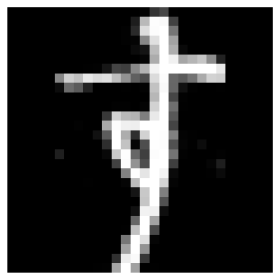

In [ ]:
idx = randint(0, len(train_sec) - 1)
sample = train_sec[idx]
plt.axis('off')
plt.imshow(sample[0].reshape(28,28), cmap = 'gray');

Se utiliza el modelo seleccionado para **`predecir la clase`** de la observación anterior. Nótese que corresponde a la clase $2$; esto tiene sentido, porque la imagen contiene la letra "su" y es la de la tercera columna en la tabla mostrada al comienzo (la lectura tradicional japonesa se realiza de derecha a izquierda).

In [ ]:
X = sample[0].to(device)
_, y = torch.max(final_model(X), 0)
print(y.item())

2


De todas formas, se imprime la **`etiqueta`** que se encuentra guardada en el conjunto de datos.

In [ ]:
print(sample[1].item())

2.0


Adicionalmente, se imprimen los **`parámetros`** del mejor modelo obtenido.

In [ ]:
for name, param in final_model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc1.weight tensor([[-0.0203,  0.0079,  0.0068,  ..., -0.0080,  0.0118,  0.0100],
        [ 0.0248,  0.0187, -0.0015,  ...,  0.0177, -0.0287,  0.0338],
        [ 0.0352, -0.0297, -0.0003,  ..., -0.0015, -0.0165, -0.0191],
        ...,
        [ 0.0200,  0.0177, -0.0060,  ..., -0.0015, -0.0263, -0.0162],
        [ 0.0211, -0.0092,  0.0033,  ...,  0.0109, -0.0239,  0.0063],
        [ 0.0153,  0.0164, -0.0137,  ...,  0.0147, -0.0079, -0.0244]])
fc1.bias tensor([ 1.9760e-03,  9.7731e-03,  2.8334e-02,  2.9887e-02, -1.4230e-02,
        -3.3899e-02,  1.3498e-02,  2.3740e-02, -2.1897e-02, -1.5735e-03,
        -1.9051e-03,  1.7573e-02, -3.5237e-02,  2.1375e-02, -2.8777e-02,
         6.3948e-03,  1.2916e-02,  1.8532e-02, -5.7900e-03,  2.1693e-02,
         8.4364e-03,  4.6006e-03, -1.2105e-02, -9.4079e-03, -1.1704e-02,
         1.3952e-02, -2.9302e-02, -2.3529e-02, -1.1203e-02,  3.1473e-02,
        -2.9044e-02,  2.7129e-02,  6.7392e-04,  6.1799e-03, -2.0570e-02,
         2.6656e-02,  2.4531e-02, -

# **Análisis de resultados**
---

Finalmente se encontró que el modelo entrenado por medio de una **`red neuronal`** con dos capas ocultas obtuvo el mejor desempeño al describir la variable objetivo (**`label`**) en los datos de prueba, ya que se obtuvo un valor del $86.18\%$ para la métrica utilizada.

Adicionalmente, se notó que un valor de $0.0005$ fue la mejor alternativa para la tasa de aprendizaje y no fue necesario modificar, simplificar o estandarizar los datos para mejorar las predicciones.

# **Referencias**
---
* [Kaggle - Japanese Characters](https://www.kaggle.com/datasets/notshrirang/japanese-characters)
* [ScikitLearn - API Reference](https://scikit-learn.org/stable/modules/classes.html#)
* [Introduction to PyTorch](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.ipynb#scrollTo=u-L7YQmcHvX8)
* [Taller de Redes Neuronales](https://colab.research.google.com/drive/1W6hJhlQ3n0EvE_XYbeK9dG7fF9E49r8r#scrollTo=QZs4EuDTuVai)
* [PyTorch - Documentation](https://pytorch.org/docs/stable/index.html)
* [Sekai Kokeshi - Hiragana Charts](https://sekaikokeshi.com/5freeprintable-hiraganacharts/)

# **Créditos**
---
* Samuel David Moreno Vahos